# Housing Price Prediction with ML and Feature Engineering

This notebook builds a machine learning pipeline to predict housing prices using a 200K-row dataset from Kaggle. It emphasizes engineered features like `luxury_score`, interpretable SHAP analysis, and calibrated prediction intervals.  
**Final performance:** RMSE ≈ \$94,000, R² ≈ 0.94

### Setup & Imports

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

### Data Loading & Initial Exploration
In this section, we load the housing dataset and perform an initial exploration to understand its structure, size, and key variables. This includes:
- Inspecting data types and missing values
- Reviewing basic summary statistics
- Previewing a sample of the dataset

The goal is to get a high-level sense of the data and identify any immediate issues (e.g. nulls, outliers, or formatting inconsistencies) before moving into feature engineering and modeling.

In [50]:
unfiltered = pd.read_csv('data/dataset.csv')
unfiltered.head()
print(f"Dataset contains {unfiltered.shape[0]:,} rows and {unfiltered.shape[1]} columns.")

Dataset contains 200,000 rows and 47 columns.


In [51]:
# Check for missing values
unfiltered.isnull().sum().sort_values(ascending=False)

sale_nbr            42182
subdivision         17550
submarket            1717
sale_price              0
sale_warning            0
join_status             0
sale_date               0
join_year               0
latitude                0
area                    0
longitude               0
city                    0
zoning                  0
present_use             0
id                      0
land_val                0
imp_val                 0
year_reno               0
year_built              0
sqft                    0
sqft_1                  0
sqft_fbsmt              0
sqft_lot                0
fbsmt_grade             0
condition               0
stories                 0
beds                    0
bath_full               0
bath_3qtr               0
bath_half               0
grade                   0
garb_sqft               0
gara_sqft               0
golf                    0
wfnt                    0
noise_traffic           0
view_rainier            0
view_olympics           0
greenbelt   

In [52]:
# Summary statistics for numerical features
unfiltered.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
id,200000.0,99999.500000,57735.171256,0.0000,49999.7500,99999.5000,149999.2500,1.999990e+05
sale_price,200000.0,584149.494690,417059.519757,50293.0000,305000.0000,459950.0000,724950.0000,2.999950e+06
sale_nbr,157818.0,2.162599,1.113090,1.0000,1.0000,2.0000,3.0000,1.100000e+01
join_year,200000.0,2023.403600,6.241643,1999.0000,2025.0000,2025.0000,2025.0000,2.025000e+03
latitude,200000.0,47.549248,0.142710,47.1552,47.4465,47.5628,47.6735,4.777780e+01


### Exploratory Data Analysis (EDA)

In this section, we explore patterns in the raw housing data to understand how different features relate to `sale_price`, the target variable. This helps guide future steps like feature engineering and transformation.

We begin by visualizing the distribution of sale prices, which appear heavily right-skewed—indicating that a log transformation may be appropriate later in preprocessing.

Next, we investigate geographic patterns using `latitude` and `longitude`, revealing clear clusters of high-price homes in specific regions. This suggests that location is a strong signal worth preserving or encoding further.

We also examine key numeric features such as square footage, number of bedrooms/bathrooms, and quality grades. A boxplot of `grade` vs `sale_price` shows a strong ordinal trend, confirming it as a useful feature. Similarly, we find that `imp_val` (improvement value) has a stronger correlation with sale price than `land_val`, aligning with the intuition that home structures drive more value than raw land in developed areas.

Finally, we compute correlation matrices in two thematic groups—home size/structure and quality/view-related features—to better isolate linear relationships with the target.

The insights here directly inform our cleaning and feature engineering decisions in the next stage.

In [53]:
# Set style
sns.set_theme(style="whitegrid")

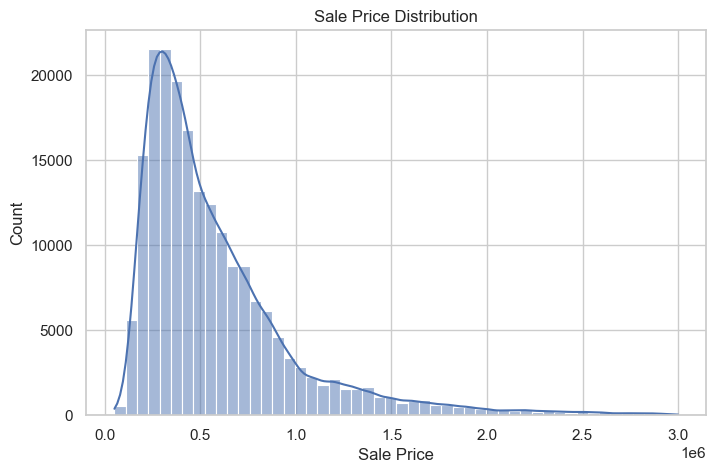

In [54]:
# Plot the raw distribution of sale prices
plt.figure(figsize=(8, 5))
sns.histplot(unfiltered['sale_price'], bins=50, kde=True)

# Add labels and title
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.show()

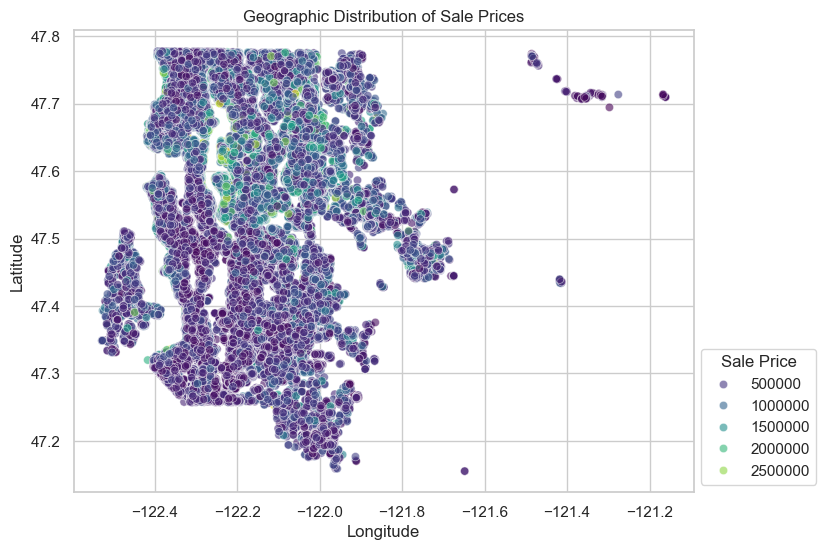

In [55]:
# Scatter plot to visualize how prices vary across location
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='longitude',
    y='latitude',
    hue='sale_price',           # Color points by price
    data=unfiltered,
    palette='viridis',
    alpha=0.6                   # Slight transparency for better overlap visibility
)

# Add plot details
plt.title('Geographic Distribution of Sale Prices')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Sale Price', loc='lower left', bbox_to_anchor=(1, 0))
plt.show()

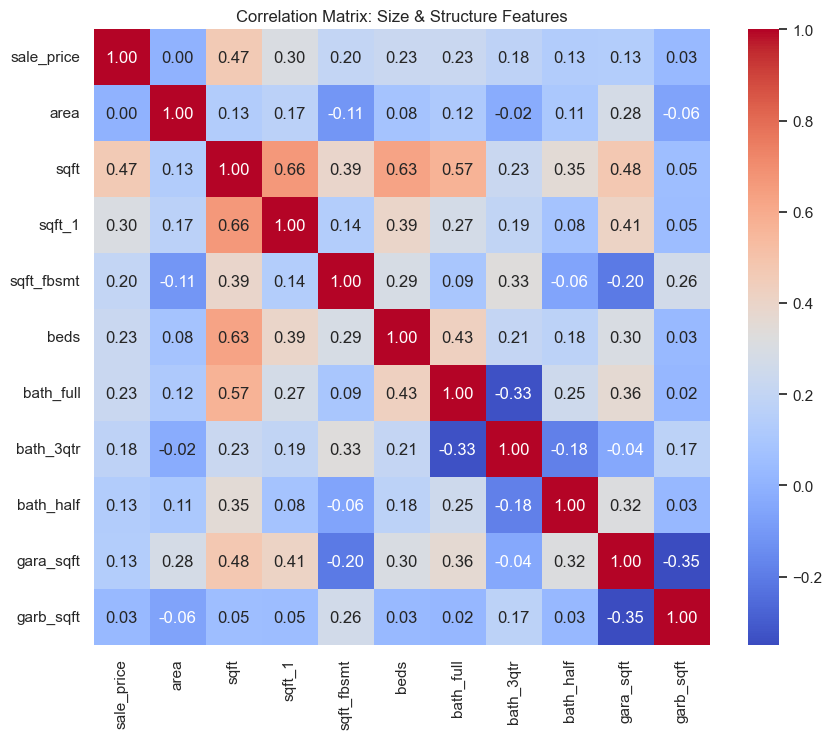

In [56]:
# --- First correlation group: Size & Structure ---
size_features = [
    'sale_price', 'area', 'sqft', 'sqft_1', 'sqft_fbsmt',
    'beds', 'bath_full', 'bath_3qtr', 'bath_half',
    'gara_sqft', 'garb_sqft'
]

# Drop rows with missing values for this group
corr1 = unfiltered[size_features].dropna().corr()

# Plot heatmap for size-related features
plt.figure(figsize=(10, 8))
sns.heatmap(corr1, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix: Size & Structure Features')
plt.show()

Text(0.5, 1.0, 'Sale Price vs Square Footage')

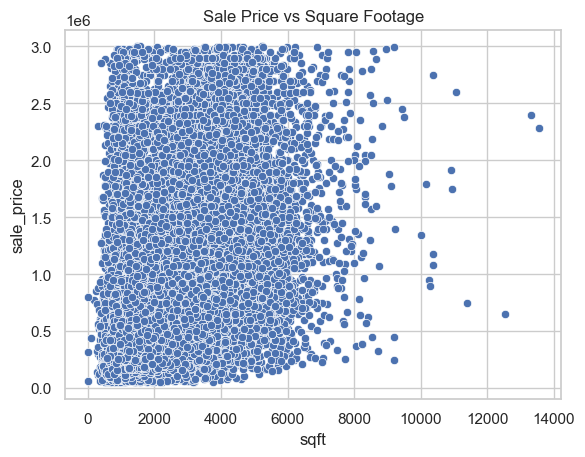

In [57]:
# Scatterplot to show the distribution between sqft and sale price
sns.scatterplot(x='sqft', y='sale_price', data=unfiltered)
plt.title('Sale Price vs Square Footage')

Text(0.5, 1.0, 'Sale Price vs 1st Floor Square Footage')

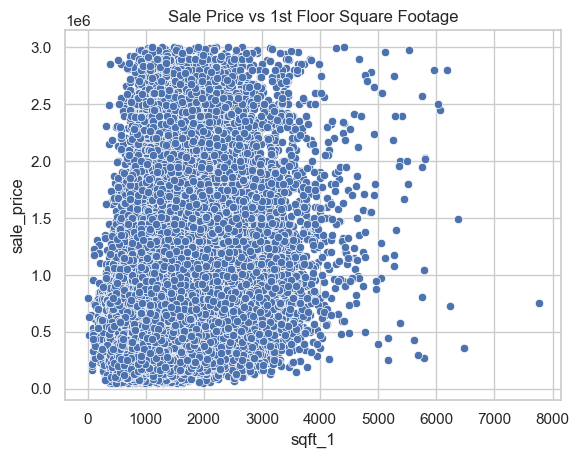

In [58]:
# Scatterplot to show the distribution between first floor square feet and sale price
sns.scatterplot(x='sqft_1', y='sale_price', data=unfiltered)
plt.title('Sale Price vs 1st Floor Square Footage')

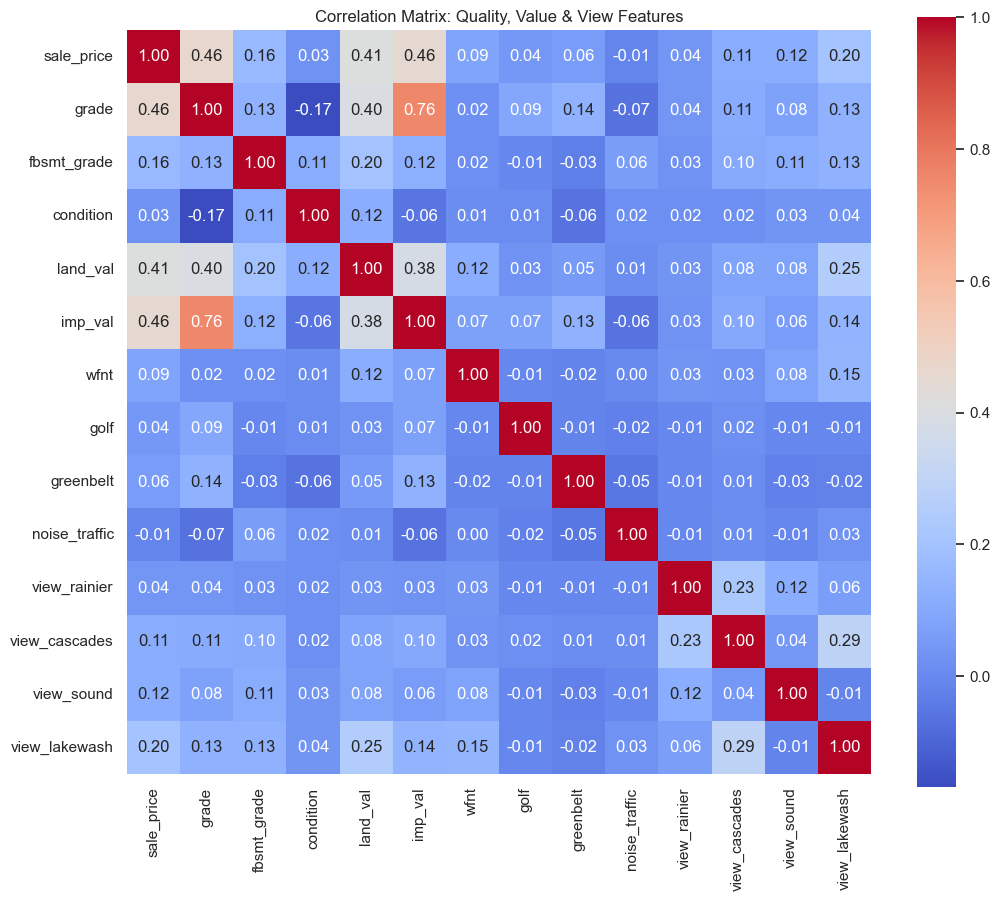

In [59]:
# --- Second correlation group: Quality, Value & Views ---
quality_features = [
    'sale_price', 'grade', 'fbsmt_grade', 'condition',
    'land_val', 'imp_val',
    'wfnt', 'golf', 'greenbelt', 'noise_traffic',
    'view_rainier', 'view_cascades', 'view_sound', 'view_lakewash'
]

# Drop rows with missing values for this group
corr2 = unfiltered[quality_features].dropna().corr()

# Plot heatmap for quality/view-related features
plt.figure(figsize=(12, 10))
sns.heatmap(corr2, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix: Quality, Value & View Features')
plt.show()


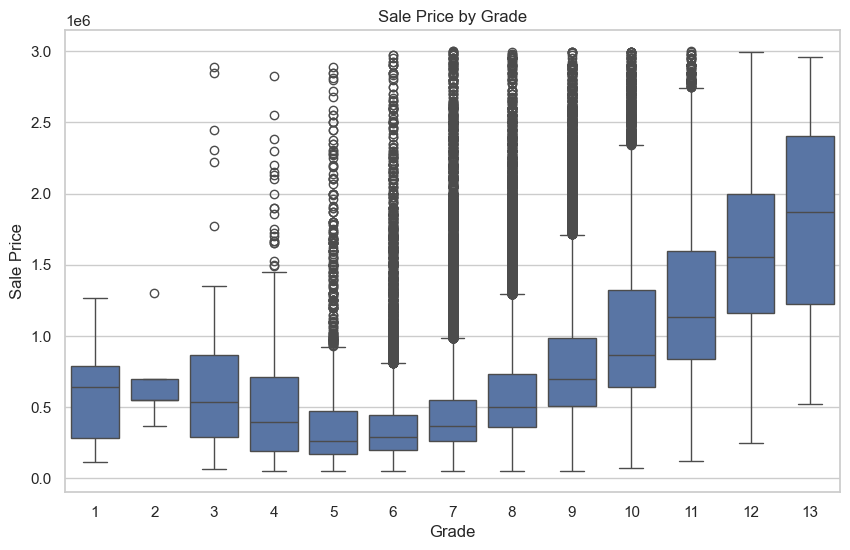

In [60]:
# Boxplot to visualize how sale price varies by home grade
plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='sale_price', data=unfiltered)

# Add axis labels and a title
plt.title('Sale Price by Grade')
plt.xlabel('Grade')
plt.ylabel('Sale Price')
plt.show()

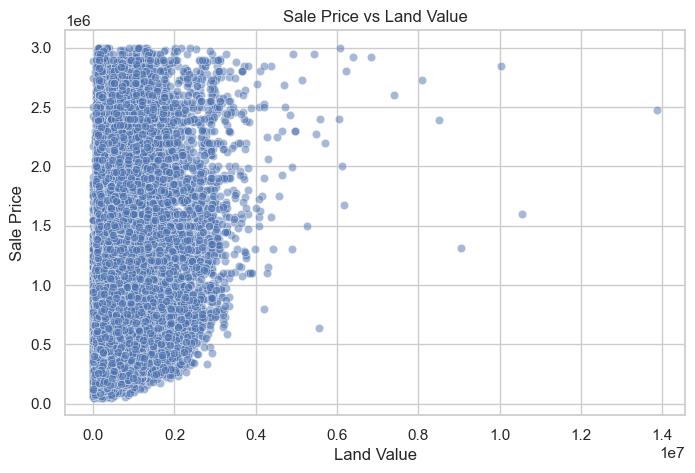

In [61]:
# Scatterplot: land value vs sale price
plt.figure(figsize=(8, 5))
sns.scatterplot(x='land_val', y='sale_price', data=unfiltered, alpha=0.5)
plt.title('Sale Price vs Land Value')
plt.xlabel('Land Value')
plt.ylabel('Sale Price')
plt.show()

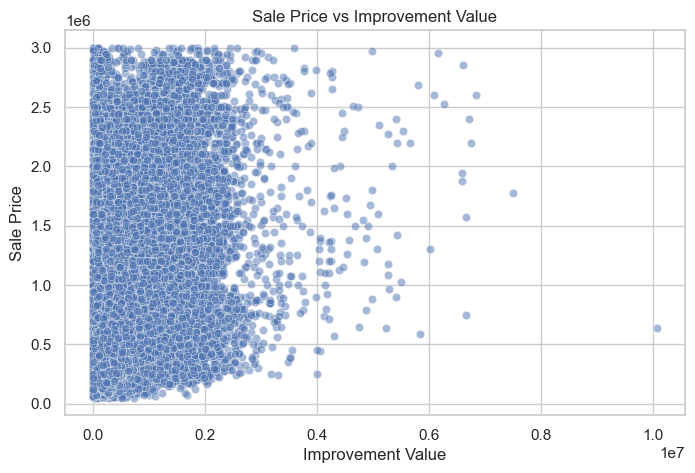

In [62]:
# Scatterplot: improvement value vs sale price
plt.figure(figsize=(8, 5))
sns.scatterplot(x='imp_val', y='sale_price', data=unfiltered, alpha=0.5)
plt.title('Sale Price vs Improvement Value')
plt.xlabel('Improvement Value')
plt.ylabel('Sale Price')
plt.show()


### Data Cleaning and Feature Engineering

We perform light data cleaning and then construct new features to enhance the model’s ability to capture pricing signals. Key transformations include:

- Handling missing values and preserving null flags (e.g. `Salenumber_missing`)
- Creating normalized and aggregated features like `total_bath` and `age`
- Applying a log transformation to reduce skew in `sale_price`
- Defining a binary `is_luxury` flag using 90th percentile thresholds for size, quality, and bathroom count along with a `luxury_score`
- Adding interaction terms that amplify price signals for luxury buyers
- Encoding all categorical variables using `OrdinalEncoder` for compatibility with tree-based models

In [72]:
# Rename for clarity (optional)
df = unfiltered.copy()

# --- Basic cleanup ---
df = df.drop(columns=['id'])  # Drop ID column (not useful for modeling)
df['Salenumber_missing'] = df['sale_nbr'].isnull().astype(int)  # Binary flag for missing sale numbers
df['sale_nbr'] = df['sale_nbr'].fillna(-1)  # Fill missing sale_nbr with -1 to preserve row

df['subdivision'] = df['subdivision'].fillna('Unknown')  # Fill unknown subdivision with string label
df['submarket'] = df['submarket'].fillna('Unknown')

df['sqft'].replace(0, np.nan)

0         1560.0
1         2040.0
2         1640.0
3         2610.0
4         4040.0
           ...  
199995    1870.0
199996    3340.0
199997    1690.0
199998    2080.0
199999    1320.0
Name: sqft, Length: 200000, dtype: float64

In [73]:
# --- Feature Engineering ---

# Age of home at time of sale
df['age'] = df['sale_date'].str[:4].astype(int) - df['year_built']

# Total bath count weighted by type (full = 1, 3/4 = 0.75, half = 0.5)
df['total_bath'] = df['bath_full'] + df['bath_half'] * 0.5 + df['bath_3qtr'] * 0.75

In [74]:
# Extract year of sale from sale_date
df['sale_year'] = df['sale_date'].str[:4].astype(int)

# Years since last renovation; -1 if reno year is 0 or in the future
df['reno_age'] = np.where(
    (df['year_reno'] == 0) | (df['year_reno'] > df['sale_year']), -1,
    df['sale_year'] - df['year_reno']
)

# Log transformation to reduce skew in sale price
df['log_sale_price'] = np.log1p(df['sale_price'])

In [86]:
# --- Luxury classification ---

# Thresholds for top 10% in various features
luxury_cutoffs = {
    'sqft': df['sqft'].quantile(0.9),
    'grade': df['grade'].quantile(0.9),
    'imp_val': df['imp_val'].quantile(0.9),
    'total_bath': df['total_bath'].quantile(0.9)
}

# Create binary is_luxury flag if any criteria are met
df['is_luxury'] = (
    (df['sqft'] >= luxury_cutoffs['sqft']) |
    (df['grade'] >= luxury_cutoffs['grade']) |
    (df['imp_val'] >= luxury_cutoffs['imp_val']) |
    (df['total_bath'] >= luxury_cutoffs['total_bath'])
).astype(int)

# Count how many luxury conditions are met
df['luxury_score'] = sum(
    (df[col] >= luxury_cutoffs[col]).astype(int)
    for col in luxury_cutoffs
)

In [87]:
# --- Interaction terms with luxury flag ---
df['luxury_x_sqft'] = df['is_luxury'] * df['sqft']
df['luxury_x_sqft_1'] = df['is_luxury'] * df['sqft_1']
df['luxury_x_subdivision'] = df['is_luxury'] * df['subdivision']
df['luxury_x_grade'] = df['is_luxury'] * df['grade']
df['luxury_x_total_bath'] = df['is_luxury'] * df['total_bath']

In [88]:
# --- Encode all categorical variables ---
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
df[cat_cols] = OrdinalEncoder().fit_transform(df[cat_cols])

### Baseline Model Comparison (Excluding XGBoost)

Before finalizing XGBoost as the best-performing model, we trained and evaluated several other ensemble-based regressors using the same feature set and evaluation pipeline.

The models compared include:

- **Random Forest** — a bagged tree ensemble that often serves as a strong baseline.
- **LightGBM** — a gradient boosting framework optimized for speed and performance.
- **CatBoost** — a gradient boosting method that handles categorical features natively.

Each model was evaluated on the same held-out test set using RMSE and R². This comparison helped validate that XGBoost was the most effective choice for this task.

In [106]:
# Quantile filtering to remove extreme log-sale-price outliers from training only
q_low = df['log_sale_price'].quantile(0.005)
q_high = df['log_sale_price'].quantile(0.995)

train_filtered = df[(df['log_sale_price'] >= q_low) & (df['log_sale_price'] <= q_high)]

In [ ]:
# Define features and target
X = train_filtered.drop(columns=['sale_price', 'log_sale_price'])
y = train_filtered['log_sale_price']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define baseline models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "CatBoost": CatBoostRegressor(n_estimators=200, verbose=0, random_state=42)
}

# Evaluate each model on the same test set
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict on test set (log scale)
    y_pred_real = np.expm1(y_pred)  # Convert back to real dollar values
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    r2 = r2_score(y_test_real, y_pred_real)
    print(f"{name} | RMSE: {rmse:.2f} | R²: {r2:.4f}")

Random Forest | RMSE: 107624.73 | R²: 0.9224
LightGBM | RMSE: 100085.37 | R²: 0.9329
CatBoost | RMSE: 98730.87 | R²: 0.9347


### Model Training and Evaluation

We begin by tuning XGBoost hyperparameters using `RandomizedSearchCV` with 3-fold cross-validation.  
The search explores combinations of tree depth, learning rate, regularization, and sampling ratios, and selects the model with the lowest root mean squared error (RMSE).

Once the best configuration is found, we retrain it on the full training set and evaluate performance on a held-out test set using RMSE and R².  
All predictions are converted back from log scale to real dollar amounts for interpretability.

In [ ]:
# Define hyperparameter grid for randomized search
xgb_param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 1.5, 2]
}

# Set up randomized search with 3-fold CV
xgb_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42),
    param_distributions=xgb_param_grid,
    n_iter=30,
    cv=3,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    random_state=42
)

# Fit the search on the training set
xgb_search.fit(X_train, y_train)

# Retrieve the best model
best_xgb = xgb_search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.7; total time=   5.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.7; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.7; total time=   4.1s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_est

In [92]:
# Use best model from hyperparameter tuning
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

y_pred_real_xgb_best = np.expm1(y_pred)  # Convert log predictions
y_test_real_xgb_best = np.expm1(y_test)  # Convert log test

rmse = np.sqrt(mean_squared_error(y_test_real_xgb_best, y_pred_real_xgb_best))
r2 = r2_score(y_test_real_xgb_best, y_pred_real_xgb_best)
print("Best XGBoost Model RMSE:", rmse)
print("Best XGBoost Model R^2:", r2)

Best XGBoost Model RMSE: 94601.28360470082
Best XGBoost Model R^2: 0.9400788448488508


### Residual and Prediction Diagnostics

To further evaluate model performance, we visualize residuals and predicted values to check for patterns in model error.

These plots help assess whether the model is biased, underfits in certain price ranges, or consistently under/over-predicts.

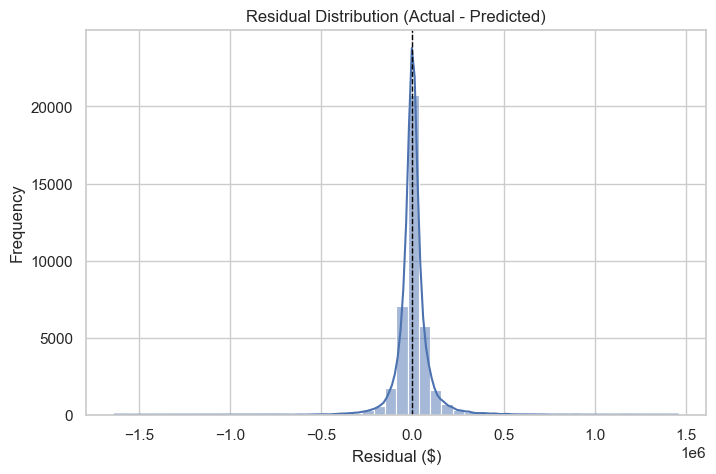

In [93]:
# --- 1. Residuals ---
residuals = y_test_real_xgb_best - y_pred_real_xgb_best

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Residual ($)")
plt.ylabel("Frequency")
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.show()

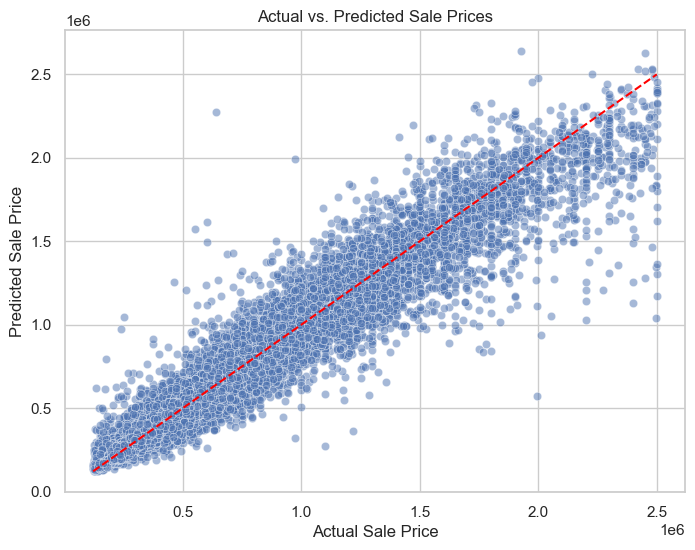

In [94]:
# --- 2. Actual vs. Predicted Scatterplot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_real_xgb_best, y=y_pred_real_xgb_best, alpha=0.5)
plt.plot([y_test_real_xgb_best.min(), y_test_real_xgb_best.max()],
         [y_test_real_xgb_best.min(), y_test_real_xgb_best.max()],
         color='red', linestyle='--')  # perfect prediction line
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Prices")
plt.show()


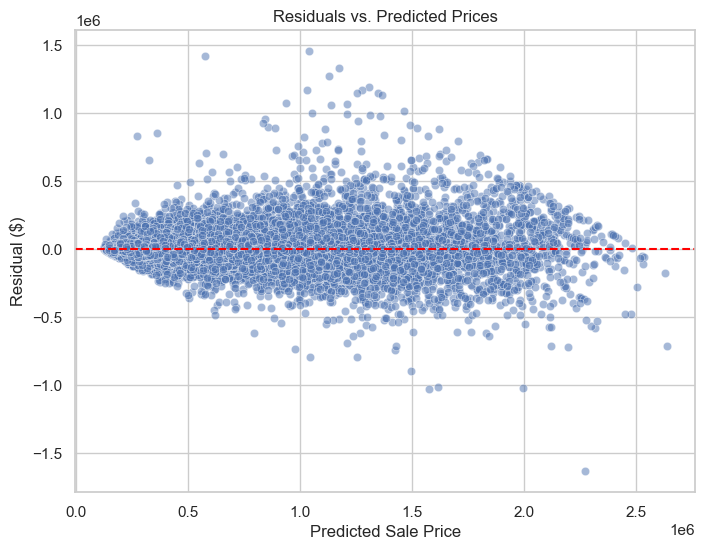

In [95]:
# --- 3. Residuals vs. Predicted ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_real_xgb_best, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residual ($)")
plt.title("Residuals vs. Predicted Prices")
plt.show()

#### Interpretation

The residual and prediction plots show that the model performs well overall, with some expected variance in higher price ranges:
- **Actual vs. Predicted:** Most predictions fall close to the diagonal line, especially for mid-range homes. The spread increases slightly at higher price points, suggesting more uncertainty for luxury properties.
- **Residual Distribution:** The residuals are centered around zero with a sharp peak and light tails, indicating no major bias and a good fit overall. A few large residuals correspond to high-priced homes.
- **Residuals vs. Predicted:** Residuals are mostly evenly distributed across the predicted price range, though variance increases with price. This is a typical pattern in real estate data and suggests slight heteroscedasticity.

These diagnostics confirm that the XGBoost model generalizes well and is not heavily overfitting or systematically biased.


## Model Interpretability

To understand which features drive the model’s predictions, we use two complementary approaches:

- **XGBoost Feature Importance** ranks features based on how much they improve decision tree splits. This highlights which features the model relied on most during training.
- **SHAP (SHapley Additive exPlanations)** assigns each feature a contribution score for each prediction, showing both magnitude and direction of impact. This helps confirm that the model is learning meaningful patterns rather than overfitting to noise.

100%|===================| 39589/39605 [15:12<00:00]        

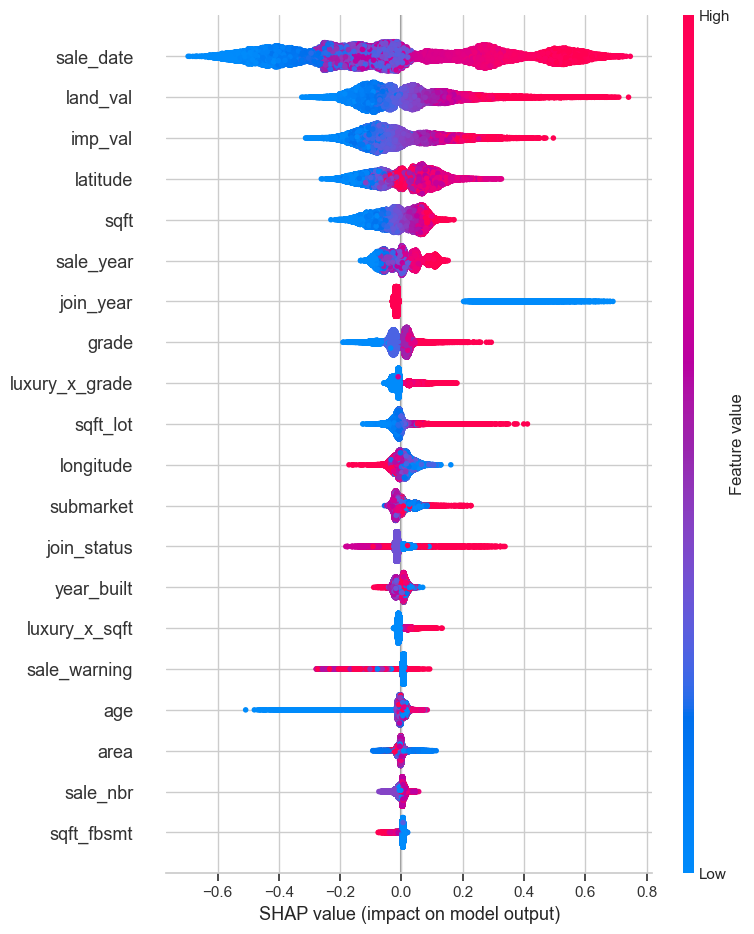

In [96]:
# Initialize SHAP explainer using the trained XGBoost model
explainer = shap.Explainer(best_xgb, X_train, feature_names=X_train.columns)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot (global importance)
shap.summary_plot(shap_values, X_test)

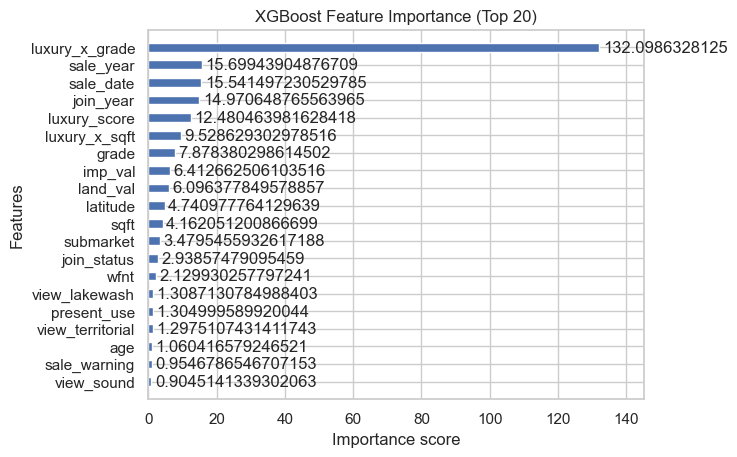

In [100]:
# Plot feature importance by weight (default)
xgb.plot_importance(best_xgb, max_num_features=20, height=0.5, importance_type='gain')
plt.title("XGBoost Feature Importance (Top 20)")
plt.show()

#### Feature Importance vs. SHAP Summary

The gain-based XGBoost feature importance plot ranks features by how much they contributed to improving model splits. Here, engineered features like `luxury_x_grade`, `sale_year`, and `luxury_score` dominate — confirming that luxury-related interactions strongly influence predicted price.

However, traditional feature importance does not capture **directionality** or **nonlinear effects**.

The SHAP summary plot addresses this by showing how high or low values of each feature push predictions up or down. For example:
- Higher `land_val`, `imp_val`, and `sqft` values consistently increase predicted price
- Certain temporal signals (like `sale_date`) show asymmetric effects
- Engineered features like `luxury_x_grade` still matter, but their impact depends on the context of other features

Together, these plots give a fuller picture of what the model has learned — both in terms of **magnitude** and **behavior**.

In [103]:
# Save the best XGBoost model to disk
joblib.dump(best_xgb, "models/final_xgb_model.pkl")

['models/final_xgb_model.pkl']

## Conclusion

This notebook demonstrated an end-to-end pipeline for predicting housing prices using XGBoost and engineered features.

We achieved strong performance (RMSE ≈ $94k, R² ≈ 0.94 and validated the model using residual diagnostics and SHAP explanations. Key drivers included luxury-related interactions, square footage, and improvement value.

Future directions include incorporating geospatial clustering, modeling uncertainty, or deploying the model via a web interface.